## 1) Preprocess all the necessary variables
### 1.1) Build feature, target and initial normalization files

In [1]:
#!ln -s /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain \
#/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.utils import limit_mem
import tensorflow as tf
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

Using TensorFlow backend.
/home/t/Tom.Beucler/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [19]:
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


In [173]:
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/'
import xarray as xr
ds = xr.open_dataset(DATADIR + 'AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0000-01-01-00000.nc', 
                     decode_times=False)
# The large-scale snow rate equivalent needs to be multiplied by 1e-3 for water conservation
print(ds.PRECTEND.attrs)
print(ds.PRECTEND.mean(dim=['lon','lat','time']))
print(ds.PRECTEND.std(dim=['lon','lat','time']))
# The total precipitation rate is in volume rate/surface units
print(ds.PRECT.attrs)
print(ds.PRECT.mean(dim=['lon','lat','time']))
print(ds.PRECT.std(dim=['lon','lat','time']))
# Water vapor variable
print(ds.QAP.mean(dim=['lon','lat','time']))
# Latent heat flux
print('LHF=',ds.LHFLX.mean(dim=['lon','lat','time']))

OrderedDict([('units', 'm/s'), ('long_name', 'Large-scale (stable) snow rate (water equivalent)'), ('cell_method', 'time: mean')])
<xarray.DataArray 'PRECTEND' ()>
array(4.809106e-07, dtype=float32)
<xarray.DataArray 'PRECTEND' ()>
array(2.617815e-05, dtype=float32)
OrderedDict([('units', 'm/s'), ('long_name', 'Total (convective and large-scale) precipitation rate'), ('cell_method', 'time: mean')])
<xarray.DataArray 'PRECT' ()>
array(3.31902e-08, dtype=float32)
<xarray.DataArray 'PRECT' ()>
array(1.147337e-07, dtype=float32)
<xarray.DataArray 'QAP' (lev: 30)>
array([1.712285e-06, 1.681808e-06, 1.394103e-06, 1.487490e-06, 1.439422e-06,
       1.390901e-06, 1.384163e-06, 1.423204e-06, 1.569639e-06, 2.076636e-06,
       3.863986e-06, 8.995262e-06, 2.052436e-05, 4.320895e-05, 8.541442e-05,
       1.625194e-04, 2.930840e-04, 5.206625e-04, 9.158371e-04, 1.510275e-03,
       2.371259e-03, 3.607772e-03, 4.945062e-03, 5.719575e-03, 6.302443e-03,
       6.846427e-03, 7.309671e-03, 7.664527e-03, 

In [25]:
!python cbrain/Test01_preprocess_aqua.py \
--config pp_config/32col_mp_ref_tbeucler_local.yml \
--aqua_names '*.h1.0000-*-01-*' \
--out_pref 32_col_mp_3d_train

GitPython not found. Please install for better reproducibility.
Time checkpoint reading data: 0.38 s
Number of time steps: 576
Cut time steps: [ 47  95 143 191 239 287 335 383 431 479 527]
Cut time steps: [ 47  95 143 191 239 287 335 383 431 479 527]
Time checkpoint create datasets: 0.48 s
Time checkpoint reshape and rechunk: 5.54 s
Compute means and stds
Saving normalization file: /local/Tom.Beucler/SPCAM_PHYS/32_col_mp_3d_train_norm.nc
Time checkpoint normalization arrays: 85.72 s
Time checkpoint rechunk and ds: 86.69 s
Save features: /local/Tom.Beucler/SPCAM_PHYS/32_col_mp_3d_train_features.nc
Save targets: /local/Tom.Beucler/SPCAM_PHYS/32_col_mp_3d_train_targets.nc
Total time: 123.85 s


In [17]:
!ls $TRAINDIR
%cd $TRAINDIR
!pwd
#!rm 32_col*

/data/Tom.Beucler/SPCAM_PHYS
/data/Tom.Beucler/SPCAM_PHYS
rm: cannot remove '32_col*': No such file or directory


### 1.2) Shuffle the data
tgb - 1/16/2019 - Adapted from Stephan's entire worlflow for 32 column run

In [26]:
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
!python cbrain/shuffle_ds.py -h

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
usage: shuffle_ds.py [-h] [--method METHOD] [--pref PREF]
                     [--random_seed RANDOM_SEED] [--chunk_size CHUNK_SIZE]
                     [--verbose VERBOSE]

optional arguments:
  -h, --help            show this help message and exit
  --method METHOD       [Meticulous or fast]
  --pref PREF           Prefix. ie without the _features.nc
  --random_seed RANDOM_SEED
                        Random seed for shuffling of data.
  --chunk_size CHUNK_SIZE
                        Size of chunks for fast method
  --verbose VERBOSE     Verbosity level


In [27]:
!python cbrain/shuffle_ds.py --pref $TRAINDIR/32_col_mp_3d_train

Reading files: /local/Tom.Beucler/SPCAM_PHYS//32_col_mp_3d_train_features.nc /local/Tom.Beucler/SPCAM_PHYS//32_col_mp_3d_train_targets.nc
Creating files: /local/Tom.Beucler/SPCAM_PHYS//32_col_mp_3d_train_shuffle_features.nc /local/Tom.Beucler/SPCAM_PHYS//32_col_mp_3d_train_shuffle_targets.nc
GitPython not found. Please install for better reproducibility.
GitPython not found. Please install for better reproducibility.
100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.24s/it]


### 1.3) Change the output's normalization using pressure levels
#### Step 0: Load the file using xarray

In [28]:
import xarray as xr
ds.close()
ds = xr.open_dataset(TRAINDIR + '32_col_mp_3d_train_norm.nc')

In [29]:
ds.target_conv


<xarray.DataArray 'target_conv' (target_lev: 126)>
array([2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.55

#### Step 1: Check already existing normalizations
$$
\left(\frac{dq_{v,l,i}}{dt}\right)\rightarrow\frac{L_{v}}{g}\ \left(\mathrm{Missing}\ \Delta p\right)
$$
$$
\left(\frac{dT}{dt}\right)\rightarrow\frac{c_{p}}{g}\ \left(\mathrm{Missing\ }\Delta p\right)
$$
$$
{\cal F}_{\mathrm{rad}}\rightarrow1\ \left(\mathrm{All\ good}\right)
$$
$$
\mathrm{Precip}_{{\cal V}}\rightarrow\rho L_{v}\ \left(\mathrm{All\ good}\right)
$$
$$
\mathrm{Precip}_{{\mathrm{tend}, \cal V}}\rightarrow\ 10^{-3}\ \rho\ L_{v}\ \left(\mathrm{All\ good}\right)
$$
We need to multiply the first (4 variables) * (30 levels) = (120 scalars) by the vector delta_p (level)


#### Step 2: Calculate differential pressure for each level

In [30]:
# 1.1 Open the pickle files containing the pressure converters
with open(os.path.join('/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain', 'hyai_hybi.pkl'), 'rb') as f:
            hyai, hybi = pickle.load(f)
# 1.2 Takes representative value for PS since purpose is normalization
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1]; # Differential pressure [Pa]
dP

array([ 277.64523402,  512.62555644,  839.73696455, 1211.38058603,
       1519.8353678 , 1745.60062587, 1737.79353499, 1423.96241426,
       1675.21685362, 1970.80597281, 2318.55362654, 2727.6545763 ,
       3208.94680917, 3775.1596421 , 4441.27991796, 5224.93720055,
       6146.86310291, 7231.4709425 , 8507.44917989, 8510.85484028,
       7811.29226089, 6591.71789885, 4899.05960858, 2836.21996641,
       2660.87651253, 2463.98309246, 2246.78721279, 2010.62900014,
       1757.35657103, 1488.78097534])

#### Step 3: Multiply Q/T tendency components of the norm. vector by dp

In [31]:
import numpy as np

ds.target_conv[:120] = np.multiply(ds.target_conv[:120],np.concatenate((dP,dP,dP,dP)))

In [32]:
ds.target_conv

<xarray.DataArray 'target_conv' (target_lev: 126)>
array([7.081169e+07, 1.307420e+08, 2.141697e+08, 3.089551e+08, 3.876245e+08,
       4.452045e+08, 4.432134e+08, 3.631727e+08, 4.272536e+08, 5.026418e+08,
       5.913327e+08, 6.956713e+08, 8.184219e+08, 9.628309e+08, 1.132721e+09,
       1.332588e+09, 1.567719e+09, 1.844342e+09, 2.169772e+09, 2.170640e+09,
       1.992221e+09, 1.681177e+09, 1.249475e+09, 7.233602e+08, 6.786399e+08,
       6.284236e+08, 5.730291e+08, 5.127984e+08, 4.482028e+08, 3.797043e+08,
       7.081169e+07, 1.307420e+08, 2.141697e+08, 3.089551e+08, 3.876245e+08,
       4.452045e+08, 4.432134e+08, 3.631727e+08, 4.272536e+08, 5.026418e+08,
       5.913327e+08, 6.956713e+08, 8.184219e+08, 9.628309e+08, 1.132721e+09,
       1.332588e+09, 1.567719e+09, 1.844342e+09, 2.169772e+09, 2.170640e+09,
       1.992221e+09, 1.681177e+09, 1.249475e+09, 7.233602e+08, 6.786399e+08,
       6.284236e+08, 5.730291e+08, 5.127984e+08, 4.482028e+08, 3.797043e+08,
       7.081169e+07, 1.30

#### Step 4: Replace targ_conv in the train_norm NETCDF file with the new values

In [33]:
# 4.1 Copy old normalization file
path1 = os.path.join(TRAINDIR,'32_col_mp_3d_train_norm.nc')
path2 = os.path.join(TRAINDIR,'32_col_mp_3d_train_oldnorm.nc')
!cp $path1 $path2

In [34]:
# 4.1.CHECK that the old normalization file was properly copied
xr.open_dataset(TRAINDIR + '32_col_mp_3d_train_oldnorm.nc').target_conv

<xarray.DataArray 'target_conv' (target_lev: 126)>
array([2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.55

In [35]:
# 4.2 Create new dataset with characteristics of modified ds
new_ds = xr.Dataset({
            'feature_means': ds.feature_means,
            'feature_stds': ds.feature_stds,
            'feature_mins': ds.feature_mins,
            'feature_maxs': ds.feature_maxs,
            'target_means': ds.target_means,
            'target_stds': ds.target_stds,
            'target_mins': ds.target_mins,
            'target_maxs': ds.target_maxs,
            'feature_names': ds.feature_names,
            'target_names': ds.target_names,
            'feature_stds_by_var': ds.feature_stds_by_var,
            'target_conv': ds.target_conv
        })

In [36]:
# 4.2 Check
new_ds.target_conv

<xarray.DataArray 'target_conv' (target_lev: 126)>
array([7.081169e+07, 1.307420e+08, 2.141697e+08, 3.089551e+08, 3.876245e+08,
       4.452045e+08, 4.432134e+08, 3.631727e+08, 4.272536e+08, 5.026418e+08,
       5.913327e+08, 6.956713e+08, 8.184219e+08, 9.628309e+08, 1.132721e+09,
       1.332588e+09, 1.567719e+09, 1.844342e+09, 2.169772e+09, 2.170640e+09,
       1.992221e+09, 1.681177e+09, 1.249475e+09, 7.233602e+08, 6.786399e+08,
       6.284236e+08, 5.730291e+08, 5.127984e+08, 4.482028e+08, 3.797043e+08,
       7.081169e+07, 1.307420e+08, 2.141697e+08, 3.089551e+08, 3.876245e+08,
       4.452045e+08, 4.432134e+08, 3.631727e+08, 4.272536e+08, 5.026418e+08,
       5.913327e+08, 6.956713e+08, 8.184219e+08, 9.628309e+08, 1.132721e+09,
       1.332588e+09, 1.567719e+09, 1.844342e+09, 2.169772e+09, 2.170640e+09,
       1.992221e+09, 1.681177e+09, 1.249475e+09, 7.233602e+08, 6.786399e+08,
       6.284236e+08, 5.730291e+08, 5.127984e+08, 4.482028e+08, 3.797043e+08,
       7.081169e+07, 1.30

In [37]:
# 4.3 Write new data set to initial target_conv file
!rm $path1 # Remove normalization file

In [38]:
new_ds.to_netcdf(path1) # Save the new dataset as the new normalization file

In [39]:
# 4.3 CHECK
xr.open_dataset(path1).close() # Don't forget to close the old handler!!
xr.open_dataset(path1).target_conv # Before checking if the new normalizations are at the right place

<xarray.DataArray 'target_conv' (target_lev: 126)>
array([7.081169e+07, 1.307420e+08, 2.141697e+08, 3.089551e+08, 3.876245e+08,
       4.452045e+08, 4.432134e+08, 3.631727e+08, 4.272536e+08, 5.026418e+08,
       5.913327e+08, 6.956713e+08, 8.184219e+08, 9.628309e+08, 1.132721e+09,
       1.332588e+09, 1.567719e+09, 1.844342e+09, 2.169772e+09, 2.170640e+09,
       1.992221e+09, 1.681177e+09, 1.249475e+09, 7.233602e+08, 6.786399e+08,
       6.284236e+08, 5.730291e+08, 5.127984e+08, 4.482028e+08, 3.797043e+08,
       7.081169e+07, 1.307420e+08, 2.141697e+08, 3.089551e+08, 3.876245e+08,
       4.452045e+08, 4.432134e+08, 3.631727e+08, 4.272536e+08, 5.026418e+08,
       5.913327e+08, 6.956713e+08, 8.184219e+08, 9.628309e+08, 1.132721e+09,
       1.332588e+09, 1.567719e+09, 1.844342e+09, 2.169772e+09, 2.170640e+09,
       1.992221e+09, 1.681177e+09, 1.249475e+09, 7.233602e+08, 6.786399e+08,
       6.284236e+08, 5.730291e+08, 5.127984e+08, 4.482028e+08, 3.797043e+08,
       7.081169e+07, 1.30

## 2) Create data generator and produce data sample


### 2.1) Create data generator

In [40]:
xr.open_dataset(path1).close() # Don't forget to close xarray handler!!

In [46]:
train_gen_obj = DataGenerator(
    data_dir=TRAINDIR, 
    feature_fn='32_col_mp_3d_train_features.nc',
    target_fn='32_col_mp_3d_train_targets.nc',
    batch_size=512,
    norm_fn='32_col_mp_3d_train_norm.nc',
    fsub='feature_means',   # Subtracct the mean
    fdiv='feature_stds_by_var',    # Then divide by Std
    tmult='target_conv',    # For targets/output: use values from preprocess_aqua.
    shuffle=True,
)

Generator will have 4620288 samples in 9024 batches
Features have shape 154; targets have shape 126


In [47]:
gen = train_gen_obj.return_generator()

### 2.2) Produce data sample

In [48]:
x, y = next(gen)

In [49]:
x.shape, y.shape

((512, 154), (512, 126))

## 3) Neural network attempts (tgb - started 1/15/2019)

In [50]:
from keras.layers import *
from keras.models import *

### 3.3) Energy conservation strategy (tgb - started 1/18/2019)
#### Step 0: Load all the variables to calculate mass-weighted vertical integrals 

In [55]:
# 1) Open the file containing the normalization of the targets
ds = xr.open_dataset(TRAINDIR + '32_col_mp_3d_train_norm.nc')
# 2) Open the pickle files containing the pressure converters
with open(os.path.join('/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain', 'hyai_hybi.pkl'), 'rb') as f:
            hyai, hybi = pickle.load(f)

In [56]:
fsub = ds.feature_means.values
fdiv = ds.feature_stds_by_var.values
normq = ds.target_conv.values
print(fsub.shape)
print(fdiv.shape)
print(normq.shape)
print(hyai.shape)
print(hybi.shape)

(154,)
(154,)
(126,)
(31,)
(31,)


In [57]:
ds.close()

#### Step 1: Implement mass conservation layer

##### Enforcing mass conservation

Reference for mass and energy conservation:

(Original CAM F90 script, look for "Compute vertical integrals of dry static energy and water" in the script)  
https://gitlab.com/mspritch/spcam3.0-neural-net/blob/master/models/atm/cam/src/physics/cam1/check_energy.F90

(Stephan's energy/mass verification scripts)  
https://github.com/raspstephan/CBRAIN-CAM/blob/master/notebooks/dev/old_notebooks/energy_conservation.ipynb

##### Mass/Water conservation equation in W/m2

If the network predicts the water vapor tendency, defined as the difference between the moisture before and after physics divided by the timestep dt (normalized in energy units W/m2):
$$\delta q_{v,i,l}\left(p\right)\overset{\mathrm{def}}{=}\frac{L_{v}\Delta p_{\mathrm{norm}}}{g}\frac{q_{v,i,l}^{a}\left(p\right)-q_{v,i,l}^{b}\left(p\right)}{\Delta t}$$

The water conservation equation is (normalized in energy units W/m2):
$$\underbrace{\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\left(\delta q_{v}+\delta q_{l}+\delta q_{i}\right)}_{\mathrm{Difference\ after-before\ physics}}=\underbrace{\int_{\widetilde{t}}^{\widetilde{t}+1} \widetilde{dt}\ \left(LHF-L_{v}P-10^{-3}\cdot L_{v} P_{tend}\right)}_{\mathrm{Evap-Precip\ during\ \Delta t}}
$$

where we have defined:
$$
\widetilde{p}\overset{\mathrm{def}}{=}\frac{p}{p_{\mathrm{norm}}}
$$
$$
\widetilde{t}\overset{\mathrm{def}}{=}\frac{t}{\Delta t}
$$
The idea is to predict all variables but one. The specific humidity at the lowest level of the model (here 30) is likely to be one of the most penalized output variables as it has one of the largest tendencies (in W/m2) in the final cost function. If we predict all other variables and calculate that variable as a residual, it yields:

$$\Delta \widetilde{p}_{30} \delta q_{v}^{30}=\int_{\widetilde{t}}^{\widetilde{t}+1} \widetilde{dt}\ \left(LHF-L_{v}P-10^{-3}\cdot L_{v} P_{tend}\right)-\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\left(\delta q_{l}+\delta q_{i}\right)-\int_{0}^{\widetilde{p_{30}}}d\widetilde{p}\delta q_{v}
$$

Note that because we are already working with tendencies, the timestep variable dt is not needed in the water conservation layer.




In [113]:
class MassConservationLayer(Layer):
    
    def __init__(self, fsub, fdiv, normq, hyai, hybi, **kwargs):
        self.fsub = fsub # Subtraction for normalization of inputs 
        self.fdiv = fdiv # Division for normalization of inputs
        self.normq = normq # Normalization of output's water concentration
        self.hyai = hyai # CAM constants to calculate d_pressure
        self.hybi = hybi # CAM constants to calculate d_pressure 
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    def call(self, arrs):
        # arrs (for arrays) is a list with 
        # [inputs=inp and the output of the previous layer=densout]
        # inputs will be [n_sample, 154 = 30*5+4] with
        # [QBP, QCBP, QIBP, TBP, VBP, PS, SOLIN, SHFLX, LHFLX]
        # outputs of the previous dense layer will be [n_samples, 124 = 30*4+6-2] with
        # [DELQ\{PHQ AT LOWEST LVL}, DELCLDLIQ, DELCLDICE, 
        # TPHYSTND\{TPHYSTND AT LOWEST LVL}, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND]
        
        # Split between the inputs inp & the output of the densely connected
        # neural network, densout
        inp, densout = arrs
        
        # 0) Constants
        G = 9.80616; # Reference gravity constant [m.s-2]
        L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
        P0 = 1e5; # Reference surface pressure [Pa]
        
        # 1) Get non-dimensional pressure differences (p_tilde above)
        # In the input vector, PS is the 151st element after 
        # the first elements = [QBP, ..., VBP with shape 30*5=150]
        PS = tf.math.add( tf.math.multiply( inp[:,150], self.fdiv[150]), self.fsub[150])
        # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
        P = tf.math.add( tf.math.multiply( P0, self.hyai), \
                        tf.math.multiply( PS[:,None], self.hybi))
        dP = tf.math.subtract( P[:, 1:], P[:, :-1])
        # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
        dP_NORM = tf.math.divide( \
                  tf.math.multiply(self.normq[:30], \
                                   G), L_V)
        # dp_tilde = dp/dp_norm
        # Wondering about broadcasting here...
        # tf.div or simply \ would support broadcasting 
        dP_TILD = tf.math.divide( dP, dP_NORM)
        
        # 2) Calculate cloud water vertical integral from level 1 to level 30
        # The indices are tricky here because we are missing del(q_v)@(level 30)
        # so e.g. q_liq@(level 1) is the 30th element of the output of the 
        # previous dense layer
        CLDVEC = tf.math.multiply( dP_TILD, \
                                  tf.math.add( densout[:, 29:59], densout[:, 59:89]))
        CLDINT = tf.math.reduce_sum( CLDVEC, axis=1)
        
        # 3) Calculate water vapor vertical integral from level 1 to level 29
        VAPVEC = tf.math.multiply( dP_TILD[:, :29], \
                                  densout[:, :29])
        VAPINT = tf.math.reduce_sum( VAPVEC, axis=1)
        
        # 4) Calculate forcing on the right-hand side (Net Evaporation-Precipitation)
        # E-P is already normalized to units W.m-2 in the output vector
        # so all we need to do is input-unnormalize LHF that is taken from the input vector
        LHF = tf.math.add( tf.math.multiply( inp[:,153], self.fdiv[153]), self.fsub[153])
        # Note that total precipitation = PRECT + 1e-3*PRECTEND in the CAM model
        # PRECTEND already multiplied by 1e-3 in output vector so no need to redo it
        PREC = tf.math.add( densout[:, 122], densout[:, 123])
        
        # 5) Infer water vapor tendency at level 30 as a residual
        # Use add_n to be able to add multiple variables
        DELQV30 = tf.math.divide( \
                                 tf.math.add_n( \
                                    [LHF, tf.math.negative(PREC), \
                                    tf.math.negative(CLDINT), \
                                    tf.math.negative(VAPINT)]), \
                                 dP_TILD[:, 29])
        
        # 6) Concatenate the water tendencies with the newly inferred tendency
        # to get the final vector out of shape (#samples,125) with
        # [DELQ, DELCLDLIQ, DELCLDICE, 
        # TPHYSTND\{TPHYSTND AT SURFACE}, FSNT, FSNS, FLNT, FLNS, PRECT PRECTEND]
        # Uses https://www.tensorflow.org/api_docs/python/tf/concat
        out = tf.concat([densout[:, :29], DELQV30, densout[:, 29:]], 1)
        return out
    
    def compute_output_shape(self, input_shape):
        return input_shape[1]+(1,) # The output has size 125=30*4+6-1
    # and is ready to be fed to the energy conservation layer
    # before we reach the total number of outputs = 126

#### Step 2: Implement energy conservation layer
##### Energy conservation equation in W/m2

We start from the frozen moist static energy conservation equation:
$$
\begin{aligned}\left(\mathrm{FMSE\ conservation\ in\ Wm^{-2}}\right)\ \  & c_{p}\int_{0}^{p_{s}}\frac{dp}{g}\left(\frac{dT}{dt}\right)_{phys}+L_{v}\int_{0}^{p_{s}}\frac{dp}{g}\left(\frac{dq_{v}}{dt}\right)_{phys}-L_{f}\int_{0}^{p_{s}}\frac{dp}{g}\left(\frac{dq_{i}}{dt}\right)_{phys}\\
 & =\mathrm{LHF}+\mathrm{SHF}+\mathrm{SW}_{t}-\mathrm{SW}_{s}+\mathrm{LW}_{s}-\mathrm{LW}_{t}
\end{aligned}
$$  

and isolate the temperature tendency closest to the surface (level 30), that we calculate as a residual:  

$$
\begin{aligned}\left(\mathrm{Isolate\ lvl\ 30}\right)\ \frac{c_{p}\Delta p_{30}}{g}\left(\frac{dT}{dt}\right)_{phys,30}= & \mathrm{LHF}+\mathrm{SHF}+\mathrm{SW}_{t}-\mathrm{SW}_{s}+\mathrm{LW}_{s}-\mathrm{LW}_{t}\\
 & -c_{p}\int_{0}^{p_{30}}\frac{dp}{g}\left(\frac{dT}{dt}\right)_{phys}-L_{v}\int_{0}^{p_{s}}\frac{dp}{g}\left(\frac{dq_{v}}{dt}\right)_{phys}+L_{f}\int_{0}^{p_{s}}\frac{dp}{g}\left(\frac{dq_{i}}{dt}\right)_{phys}
\end{aligned}
$$

We now introduce the normalization used for the outputs:
$$
\delta T\left(p\right)\overset{\mathrm{def}}{=}\frac{c_{p}\Delta p_{\mathrm{norm}}}{g}\frac{T^{a}\left(p\right)-T^{b}\left(p\right)}{\Delta t}
$$
$$
\delta q_{v,i,l}\left(p\right)\overset{\mathrm{def}}{=}\frac{L_{v}\Delta p_{\mathrm{norm}}}{g}\frac{q_{v,i,l}^{a}\left(p\right)-q_{v,i,l}^{b}\left(p\right)}{\Delta t}
$$

which leads to the non-dimensional version of the residual equation:
$$
\begin{aligned}\left(\mathrm{Non-dim}\right)\Delta\widetilde{p}_{30}\delta T_{30} & =\mathrm{LHF}+\mathrm{SHF}+\mathrm{SW}_{t}-\mathrm{SW}_{s}+\mathrm{LW}_{s}-\mathrm{LW}_{t}\\
 & -\int_{0}^{\widetilde{p}_{30}}d\widetilde{p}\cdot\delta T-\int_{0}^{\widetilde{p}_{s}}d\widetilde{p}\cdot\delta q_{v}+\frac{L_{f}}{L_{v}}\int_{0}^{\widetilde{p}_{s}}d\widetilde{p}\cdot\delta q_{i}
\end{aligned}
$$

Remark: One could ask if we could have avoided a factor L_f/L_v by normalizing the ice concentration outputs using L_f * del_p/g rather than L_v * del_p/g. It would simplify the equation above, but then add a factor L_v/L_f in the mass conservation equation (previous layer). 

In [112]:
class FMSEConservationLayer(Layer):
    
    def __init__(self, fsub, fdiv, normq, hyai, hybi, **kwargs):
        self.fsub = fsub # Subtraction for normalization of inputs 
        self.fdiv = fdiv # Division for normalization of inputs
        self.normq = normq # Normalization of output's water concentration
        self.hyai = hyai # CAM constants to calculate d_pressure
        self.hybi = hybi # CAM constants to calculate d_pressure 
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    def call(self, arrs):
        # arrs (for arrays) is a list with 
        # [inputs=inp and the output of the previous layer=massout]
        # inputs will be [n_sample, 154 = 30*5+4] with
        # [QBP, QCBP, QIBP, TBP, VBP, PS, SOLIN, SHFLX, LHFLX]
        # outputs of the previous dense layer will be [n_samples, 125 = 30*4+6-1] with
        # [DELQ, DELCLDLIQ, DELCLDICE, 
        # TPHYSTND\{TPHYSTND AT LOWEST LVL}, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND]
        
        # Split between the inputs inp & the output of the densely connected
        # neural network, massout
        inp, massout = arrs
        
        # 0) Constants
        G = 9.80616; # Reference gravity constant [m.s-2]
        L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
        L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
        P0 = 1e5; # Reference surface pressure [Pa]
        
        # 1) Get non-dimensional pressure differences (p_tilde above)
        # In the input vector, PS is the 151st element after 
        # the first elements = [QBP, ..., VBP with shape 30*5=150]
        PS = tf.math.add( tf.math.multiply( inp[:,150], self.fdiv[150]), self.fsub[150])
        # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
        P = tf.math.add( tf.math.multiply( P0, self.hyai), \
                        tf.math.multiply( PS[:,None], self.hybi))
        dP = tf.math.subtract( P[:, 1:], P[:, :-1])
        # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
        dP_NORM = tf.math.divide( \
                  tf.math.multiply(self.normq[:30], \
                                   G), L_V)
        # dp_tilde = dp/dp_norm
        dP_TILD = tf.math.divide( dP, dP_NORM)
        
        # 2) Calculate latent heat vertical integral from level 1 to level 30
        LATVEC = tf.math.multiply( dP_TILD, \
                                  tf.math.add( \
                                    massout[:, :30], \
                                    tf.math_divide( tf.math.multiply( L_F, \
                                    tf.math.negative(massout[:, 60:90])), L_V)))               
        LATINT = tf.math.reduce_sum( LATVEC, axis=1)
        
        # 3) Calculate sensible heat vertical integral from level 1 to level 29
        # The temperature tendency is contained in 
        # the 91st to 119th element of the output vector
        SENVEC = tf.math.multiply( dP_TILD[:, :29], massout[:, 90:119])
        SENINT = tf.math.reduce_sum( SENVEC, axis=1)
        
        # 4) Calculate forcing on the right-hand side (Net radiation + surface ent. fluxes)
        # RHS = SHF+LHF
        RHS = inp[:,152]+inp[:,153]+\
        massout[:,119]-massout[:,120]-massout[:,121]+massout[:,122] # +SWs-SWt-LWt+LWs
        
        # 5) Infer temperature tendency at level 30 as a residual
        # Use add_n to be able to add multiple variables
        DELT30 = tf.math.divide( \
                                tf.math.add_n( \
                                   [RHS, \
                                   tf.math.negative(LATINT), \
                                   tf.math.negative(SENINT)]), \
                                dP_TILD[:, 29])
        
        # 6) Concatenate the water tendencies with the newly inferred tendency
        # to get the final vector out of shape (#samples,126) with
        # [DELQ, DELCLDLIQ, DELCLDICE, 
        # TPHYSTND, FSNT, FSNS, FLNT, FLNS, PRECT PRECTEND]
        # Uses https://www.tensorflow.org/api_docs/python/tf/concat
        out = tf.concat([massout[:, :119], DELT30, massout[:, 119:]], 1)
        
        return out
    
    def compute_output_shape(self, input_shape):
        return input_shape[1]+(1,) # The output has size 126
    # and is ready to be used in the cost function

#### Step 3: Formulate mass/energy conserving model
We start with inputs [QBP, QCBP, QIBP, TBP, VBP, PS, SOLIN, SHFLX, LHFLX] of shape 154  
We then have a few dense layers with size proportional to a power of 2
  
For now, there is no other "physically-constraining" layers than  
the mass+energy conservation layers which take input of shape 124  
  
After mass layer outputs vector of shape 125  
After energy layer outputs final vector of shape 126  
i.e. [DELQ, DELCLDLIQ, DELCLDICE, TPHYSTND, FSNT, FSNS, FLNT, FLNS, PRECT PRECTEND]

In [114]:
inp = Input(shape=(154,))
densout = Dense(124, activation='relu')(inp)
for i in range (5):
    densout = Dense(124, activation='relu')(densout)
massout = MassConservationLayer(
    input_shape=(124,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi
)([inp, densout])
out = FMSEConservationLayer(
    input_shape=(125,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi
)([inp, massout])
model1 = Model(inputs=inp, outputs=out)

ValueError: Shape must be rank 2 but is rank 1 for 'mass_conservation_layer_13/concat' (op: 'ConcatV2') with input shapes: [?,29], [?], [?,95], [].

#### Final step: Debugging
##### Mass conservation layer in Numpy

In [191]:
import numpy as np
import copy
x, y = next(gen)
inp = copy.copy(x);
ycop = copy.copy(y);
densout = np.concatenate([ycop[:,:29],ycop[:,30:119],ycop[:,120:]],1)

# 0) Constants
G = 9.80616; # Reference gravity constant [m.s-2]
L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
P0 = 1e5; # Reference surface pressure [Pa]
ind_test = 59; # Reference index to test        
    
# 1) Get non-dimensional pressure differences (p_tilde above)
# In the input vector, PS is the 151st element after 
# the first elements = [QBP, ..., VBP with shape 30*5=150]
PS = np.add( np.multiply( inp[:,150], fdiv[150]), fsub[150])
# Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
P = np.add( np.multiply( P0, hyai), \
                        np.multiply( PS[:,None], hybi))
dP = np.subtract( P[:, 1:], P[:, :-1])
print('dP=',dP[ind_test,:])
# norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
dP_NORM = np.divide( \
                  np.multiply(normq[:30], \
                                   G), L_V)
        # dp_tilde = dp/dp_norm
        # Wondering about broadcasting here...
        # tf.div or simply \ would support broadcasting 
dP_TILD = np.divide( dP, dP_NORM)
print('dP_TILD=',dP_TILD[ind_test,:])
        
        # 2) Calculate cloud water vertical integral from level 1 to level 30
        # The indices are tricky here because we are missing del(q_v)@(level 30)
        # so e.g. q_liq@(level 1) is the 30th element of the output of the 
        # previous dense layer
CLDVEC = np.multiply( dP_TILD, \
                                  np.add( densout[:, 29:59], densout[:, 59:89]))
print('CLDVEC=',CLDVEC[ind_test,:])
CLDINT = np.sum( CLDVEC, axis=1)
print('CLDINT=',CLDINT[ind_test])
        
        # 3) Calculate water vapor vertical integral from level 1 to level 29
VAPVEC = np.multiply( dP_TILD[:, :29], \
                                  densout[:, :29])
print('VAPVEC=',VAPVEC[ind_test,:])
VAPINT = np.sum( VAPVEC, axis=1)
print('VAPINT=',VAPINT[ind_test])
        
        # 4) Calculate forcing on the right-hand side (Net Evaporation-Precipitation)
        # E-P is already normalized to units W.m-2 in the output vector
        # so all we need to do is input-unnormalize LHF that is taken from the input vector
LHF = np.add( np.multiply( inp[:,153], fdiv[153]), fsub[153])
SHF = np.add( np.multiply( inp[:,152], fdiv[152]), fsub[152])
print('LHF=',LHF[ind_test])
        # Note that total precipitation = PRECT + 1e-3*PRECTEND in the CAM model
        # PRECTEND already multiplied by 1e-3 in output vector so no need to redo it
PREC = np.add( densout[:, 122], densout[:, 123])
print('PREC=',PREC[ind_test])
print('E-P=',LHF[ind_test]-PREC[ind_test])
print('E-P-CLDINT-VAPINT=',LHF[ind_test]-PREC[ind_test]-CLDINT[ind_test]-VAPINT[ind_test])
        # 5) Infer water vapor tendency at level 30 as a residual
        # Use add_n to be able to add multiple variables
# Modification 2 here !!!!!!!!!!!!!!!!!!!!!!!!
DELQV30 = np.divide(np.add(np.add(np.add(LHF,np.negative(PREC)),np.negative(CLDINT)),np.negative(VAPINT)), \
                                 dP_TILD[:, 29])
# !!!!!!!!!!!!!!!!!!!!!!!!!!
print('DELQV30=',DELQV30[ind_test])
        
        # 6) Concatenate the water tendencies with the newly inferred tendency
        # to get the final vector out of shape (#samples,125) with
        # [DELQ, DELCLDLIQ, DELCLDICE, 
        # TPHYSTND\{TPHYSTND AT SURFACE}, FSNT, FSNS, FLNT, FLNS, PRECT PRECTEND]
        # Uses https://www.tensorflow.org/api_docs/python/tf/concat
# Modification 1 here!!!!!!!!!!!!!!!!!!!!!
DELQV30 = np.expand_dims(DELQV30,1)
# !!!!!!!!!!!!!!!!!!!!!!!!!
print(a.shape)
print(densout[:, :29].shape)
print(densout[:, 29:].shape)
out = np.concatenate([densout[:, :29], DELQV30, densout[:, 29:]], 1)
print(out[5,:119]-y[5,:119]) # Should be 0

dP= [ 277.64523402  512.62555644  839.73696455 1211.38058603 1519.8353678
 1745.60062587 1737.79353499 1423.96241426 1675.21685362 1970.80597281
 2318.55362654 2727.6545763  3220.26716374 3788.47745763 4456.94763833
 5243.36945951 6168.54769163 7256.98174883 8537.46132541 8540.878996
 7838.8485304  6614.97182474 4916.34226159 2846.22543225 2670.26341446
 2472.67540874 2254.71331084 2017.72199661 1763.55608059 1493.06343056]
dP_TILD= [1.         1.00000001 1.00000003 0.99999998 1.00000003 1.00000002
 1.00000004 1.00000001 1.00000003 1.00000003 0.99999996 1.00000001
 1.00352776 1.00352774 1.00352778 1.00352769 1.00352772 1.00352778
 1.00352786 1.00352779 1.00352772 1.00352777 1.00352786 1.00352783
 1.00352786 1.00352772 1.00352779 1.0035278  1.00352775 1.00287646]
CLDVEC= [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.9477

### 3.1) A simple example

In [21]:
inp = Input(shape=(154,))
act = Dense(124, activation='relu')(inp)
for i in range (7):
    act = Dense(124, activation='relu')(act)
out = Dense(125)(act)
model1 = Model(inputs=inp, outputs=out)

In [22]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 154)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 124)               19220     
_________________________________________________________________
dense_2 (Dense)              (None, 124)               15500     
_________________________________________________________________
dense_3 (Dense)              (None, 124)               15500     
_________________________________________________________________
dense_4 (Dense)              (None, 124)               15500     
_________________________________________________________________
dense_5 (Dense)              (None, 124)               15500     
_________________________________________________________________
dense_6 (Dense)              (None, 124)               15500     
__________

In [23]:
model1.compile('adam', loss='mse')

In [24]:
model1.fit_generator(gen, train_gen_obj.n_batches, epochs=10)

Epoch 1/10
9024/9024 [==============================] - 46s 5ms/step - loss: 302.7223
Epoch 2/10
9024/9024 [==============================] - 40s 4ms/step - loss: 214.0051
Epoch 3/10
2746/9024 [========>.....................] - ETA: 27s - loss: 214.7549

KeyboardInterrupt: 

In [17]:
preds = model1.predict_on_batch(x)

In [18]:
preds.shape

(512, 125)

array([ 0.0000000e+00,  0.0000000e+00,  1.1683633e-04, -1.8150534e-04,
        2.8191236e-05, -1.2674624e-04,  3.2557498e-04, -2.3665362e-04,
        1.0368231e-04,  4.4764183e-04,  9.7565079e-04,  6.6266386e-03,
       -2.4458408e-02,  7.7702858e-02, -7.9534091e-02, -3.0769283e-01,
       -2.9614696e-01, -3.2436770e-01, -1.4933038e+01,  1.1325694e+02,
        1.1042747e+02, -1.3367409e+02, -9.7812202e+01, -1.2961019e+01,
       -2.1165226e+01, -3.0767555e+01, -1.5683941e+01,  6.6389933e+00,
       -3.9723598e+01, -5.9443699e+01,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  2.3594544e+00,  6.4320625e+01, -2.1832945e+01,
       -4.4953237e+00,  2.9705560e+00, -4.5950494e+00, -4.7523217e+00,
      

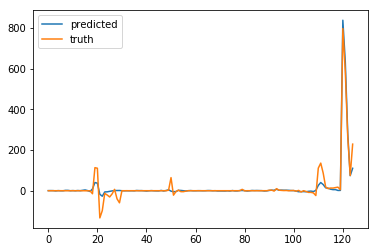

In [19]:
plt.plot(preds[413])
plt.plot(y[413])
plt.legend(['predicted','truth'])
y[413,]
#plt.axis([0,50,-50,20])

### 3.2) Implement energy conservation layer: First attempt focused on positivity
tgb - 1/18/2019 - The hard constraint on q made the optimization problem much much harder 
Two conclusions are: (1) Try to keep it soft constraints for optimization
(2) Maybe predict delta(after-before) physics to avoid getting too different values in the vectors
#### Step 0: Load input's normalization separately

In [17]:
ds = xr.open_dataset(TRAINDIR + '32_col_mp_3d_train_norm.nc')
ds

<xarray.Dataset>
Dimensions:              (feature_lev: 154, target_lev: 125)
Coordinates:
  * feature_lev          (feature_lev) int64 0 1 2 3 4 5 ... 149 150 151 152 153
  * target_lev           (target_lev) int64 0 1 2 3 4 5 ... 120 121 122 123 124
Data variables:
    feature_means        (feature_lev) float32 ...
    feature_stds         (feature_lev) float32 ...
    feature_mins         (feature_lev) float32 ...
    feature_maxs         (feature_lev) float32 ...
    target_means         (target_lev) float32 ...
    target_stds          (target_lev) float32 ...
    target_mins          (target_lev) float32 ...
    target_maxs          (target_lev) float32 ...
    feature_names        (feature_lev) object ...
    target_names         (target_lev) object ...
    feature_stds_by_var  (feature_lev) float32 ...
    target_conv          (target_lev) float32 ...

In [18]:
fsub = ds.feature_means.values
fdiv = ds.feature_stds_by_var.values
normq = ds.target_conv.values
print(fsub.shape)
print(fdiv.shape)
print(normq.shape)

(154,)
(154,)
(125,)


In [19]:
ds.close()

#### Step 1: Test the physical constraint layer in Numpy for basic debugging

In [63]:
import numpy as np
a = np.random.rand(6,3,4)
print(a)
b = np.sum(a,axis=1)
print(b)

[[[0.9818167  0.09225867 0.2593662  0.0859784 ]
  [0.27363139 0.09240143 0.50830887 0.43835565]
  [0.17405033 0.17480789 0.62610907 0.38712134]]

 [[0.05619494 0.9201926  0.40495249 0.59104755]
  [0.88541195 0.402159   0.82066004 0.91475222]
  [0.17406738 0.89249246 0.11983245 0.27512741]]

 [[0.80821145 0.90068455 0.68413879 0.10482585]
  [0.52299228 0.57263411 0.28185973 0.99129581]
  [0.33562796 0.21025477 0.11013603 0.37850126]]

 [[0.69261869 0.23141709 0.76954422 0.13540127]
  [0.44046793 0.70237374 0.1353094  0.59784221]
  [0.79895251 0.5955489  0.51146392 0.83829955]]

 [[0.98542035 0.18131295 0.69134634 0.08065755]
  [0.04284102 0.28081897 0.97091979 0.55219565]
  [0.26827134 0.1325861  0.9201834  0.36236658]]

 [[0.30669727 0.85796343 0.60440283 0.16863611]
  [0.42151053 0.92823107 0.90120357 0.07010979]
  [0.26861319 0.1545394  0.53381171 0.74998332]]]
[[1.42949843 0.359468   1.39378414 0.91145539]
 [1.11567427 2.21484406 1.34544497 1.78092719]
 [1.66683168 1.68357343 1.0761

In [24]:
import numpy as np
def safe_softplus(x, limit=30):
  if x>limit:
    return x
  else:
    return np.log(1.0 + np.exp(x))

In [25]:
print(qap.shape)
print(fsub.shape)

NameError: name 'qap' is not defined

In [100]:
x, y = next(gen) # (Input,Output) pair retrieved iteratively from the generator
testinp = x; testdensout = y;  # The output of the densely connected layer,
# which is the input for the physical constraints layer, has shape (125,)=y.shape
qbp = np.add(np.multiply(testinp[:,:90],fdiv[:90,]),fsub[:90,])
index = 5
print(qbp[index,:])
# Bound on dq/dt
np.multiply(normq[:90,],qbp[index,:])/1800

[1.8890089e-06 1.8709759e-06 1.7035223e-06 1.7005252e-06 1.6415983e-06
 1.5045957e-06 1.4606607e-06 1.4591218e-06 1.4598600e-06 1.4735780e-06
 1.5066166e-06 1.5988817e-06 2.0526277e-06 4.9225710e-06 1.0806412e-05
 2.0793159e-05 5.1943964e-05 1.3326522e-04 2.4402043e-04 3.3523864e-04
 6.6088326e-04 1.1144076e-03 1.5189773e-03 1.8160637e-03 2.0421566e-03
 2.2358480e-03 2.4027592e-03 2.5413563e-03 2.7411170e-03 2.9877913e-03
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.7347235e-18 0.0000000e+00 0.0000000e+00 2.2737368e-13 0.0000000e+00
 0.0000000e+00 9.0949470e-13 9.5405994e-09 4.6377809e-06 1.5204386e-05
 1.5759480e-05 4.7640169e-06 1.4436255e-06 1.9511208e-07 5.5640478e-05
 1.2481135e-09 1.0923745e-09 6.6391337e-14 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.000

array([7.4313283e-02, 1.3589725e-01, 2.0269047e-01, 2.9188102e-01,
       3.5351321e-01, 3.7214047e-01, 3.5965800e-01, 2.9439625e-01,
       3.4651691e-01, 4.1148993e-01, 4.9495089e-01, 6.1794227e-01,
       9.3328631e-01, 2.6331131e+00, 6.8003597e+00, 1.5393726e+01,
       4.5240860e+01, 1.3654811e+02, 2.9414923e+02, 4.0426810e+02,
       7.3145874e+02, 1.0408422e+03, 1.0544020e+03, 7.2981561e+02,
       7.6993835e+02, 7.8058862e+02, 7.6491705e+02, 7.2400189e+02,
       6.8254248e+02, 6.3026514e+02, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.2842618e-12, 0.0000000e+00, 0.0000000e+00,
       2.7408277e-07, 0.0000000e+00, 0.0000000e+00, 8.4945623e-07,
       6.6226311e-03, 1.8637701e+00, 5.7323909e+00, 5.5020161e+00,
       1.5166223e+00, 4.1127157e-01, 4.8583217e-02, 1.1737184e

In [109]:
# SOFTPLUS
import copy
qap = copy.copy(testdensout[:,:90])
print(qap)
print(qap[5,:])
for i in range(qap.shape[0]):
    for j in range (qap.shape[1]):
        qap[i,j] = safe_softplus(qap[i,j])
print(qap,qap.shape)          


[[ 0.00000000e+00  0.00000000e+00 -3.52463167e-06 ...  7.14828730e-01
  -1.94745120e-02 -5.09016812e-01]
 [ 0.00000000e+00  0.00000000e+00 -3.91810636e-06 ... -8.12336057e-02
   1.09404393e-01 -2.64686853e-01]
 [ 0.00000000e+00  0.00000000e+00 -3.83413817e-06 ...  2.25569099e-01
  -5.04336655e-02 -1.75489992e-01]
 ...
 [ 0.00000000e+00  0.00000000e+00 -4.57383749e-06 ...  4.15254906e-02
   3.08697671e-01 -1.18188016e-01]
 [ 0.00000000e+00  0.00000000e+00 -5.56462510e-06 ...  8.04110393e-02
  -4.38176608e-03  3.40724625e-02]
 [ 0.00000000e+00  0.00000000e+00 -5.02103740e-06 ... -5.38274534e-02
  -2.09472924e-01 -1.75753996e-01]]
[ 0.0000000e+00  0.0000000e+00 -3.1418069e-06 -3.6398256e-07
  3.0054719e-06 -1.6221151e-05  8.7531935e-06  1.2292489e-05
  1.0967176e-05 -6.3576708e-06  3.7818052e-07 -2.8339788e-04
 -1.0227459e-03 -2.1273026e-03 -3.6572393e-02  2.8603417e-03
 -2.7998945e-01 -4.5961341e-01  9.0005070e-01  6.8134266e-01
 -8.2287771e-01  2.3013981e-01  2.4323208e+00 -8.4881544e-0

#### Step 2: Rigorously implement the physical constraint layer in tensorflow

In [143]:
class PositiveConstraintLayer(Layer):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    def call(self, inp):
        # inputs will be [n_samples, 125 = 30*4+5] with 
        # [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, FSNT, FSNS, FLNT, FLNS, PRECT]
        
        # SOFTPLUS PART
        qap = inp[:, :90]
        remain = inp[:, 90:]
        # softplus on x_q
        qap = K.softplus(qap)
        
        # Concat out
        out = K.concatenate([qap, remain])
        
        return out
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [144]:
class CloudTendencyLayer(Layer):
    
    def __init__(self, fsub, fdiv, normq, dt=30*60, **kwargs):
        self.fsub = fsub 
        self.fdiv = fdiv
        self.normq = normq
        self.dt = dt
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    def call(self, arrs):
        # arrs (for arrays) is a list with 
        # [inputs and the output of the previous layer]
        # inputs will be [n_sample, 154 = 30*5+4] with
        # [QBP, QCBP, QIBP, TBP, VBP, PS, SOLIN, SHFLX, LHFLX]
        # outputs will be [n_samples, 125 = 30*4+5] with 
        # [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, FSNT, FSNS, FLNT, FLNS, PRECT]
        
        # Split between the inputs inp & the output of the densely connected
        # neural network, densout
        inp, densout = arrs
        
        # Identify qap and rest of vector
        qap = densout[:, :90]
        remain = densout[:, 90:]
        
        # OPTION 1
        # 1) Unnormalize qbp
        qbp = inp[:, :90]
        qbp = tf.math.add(tf.math.multiply(qbp,self.fdiv[:90,]),self.fsub[:90,])
        # 2) Calculate temporal difference
        diff = tf.math.divide(tf.math.subtract(qap,qbp),self.dt)
        # 3) Normalize the temporal difference according to output's normalization
        diff = tf.math.multiply(diff,self.normq[:90,])
        
        # Concat out
        out = K.concatenate([diff, remain])
        
        return out
    
    def compute_output_shape(self, input_shape):
        return input_shape[1]

In [60]:
class PhysicalConstraintLayer(Layer):
    
    def __init__(self, fsub, fdiv, normq, dt=30*60, **kwargs):
        self.fsub = fsub 
        self.fdiv = fdiv
        self.normq = normq
        self.dt = dt
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    def call(self, arrs):
        # arrs (for arrays) is a list with 
        # [inputs and the output of the previous layer]
        # inputs will be [n_sample, 154 = 30*5+4] with
        # [QBP, QCBP, QIBP, TBP, VBP, PS, SOLIN, SHFLX, LHFLX]
        # outputs will be [n_samples, 125 = 30*4+5] with 
        # [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, FSNT, FSNS, FLNT, FLNS, PRECT]
        
        # Split between the inputs inp & the output of the densely connected
        # neural network, densout
        inp, densout = arrs
        
        # SOFTPLUS PART
        qap = densout[:, :90]
        remain = densout[:, 90:]
        # softplus on x_q, then multiply by 10^-3 for order of magnitude
        qap = tf.math.multiply(1e-3,K.relu(qap))
        
        # FROM Q TO DQ/DT
        # OPTION 1
        # 1) Unnormalize qbp
        qbp = inp[:, :90]
        qbp = tf.math.add(tf.math.multiply(qbp,self.fdiv[:90,]),self.fsub[:90,])
        # 2) Calculate temporal difference
        diff = tf.math.divide(tf.math.subtract(qap,qbp),self.dt)
        # 3) Normalize the temporal difference according to output's normalization
        diff = tf.math.multiply(diff,self.normq[:90,])
        
        # OPTION 2
        # 1) Normalize qap
        #qap = tf.math.divide(tf.math.subtract(qap,self.fsub[:90,]),self.fdiv[:90,])
        # 2) Calculate temporal difference
        #qbp = inp[:, :90]
        #diff = tf.math.divide(tf.math.subtract(qap,qbp),self.dt)
        # 3) Unnormalize dq/dt
        #diff = tf.math.multiply(diff,self.fdiv[:90,])
        # 4) Normalize the temporal difference according to output's normalization
        #diff = tf.math.multiply(diff,self.normq[:90,])
        
        # Concat out
        out = K.concatenate([diff, remain])
        
        return out
    
    def compute_output_shape(self, input_shape):
        return input_shape[1]

In [61]:
inp = Input(shape=(154,))
densout = Dense(256, activation='relu')(inp)
for i in range(4):
    densout = Dense(256, activation='relu')(densout)
densout = Dense(125, activation='relu')(densout)
out = PhysicalConstraintLayer(
    input_shape=(125,), fsub=fsub, fdiv=fdiv, normq=normq
)([inp, densout])
m = Model(inputs=inp, outputs=out)

In [146]:
inp = Input(shape=(154,))
densout = Dense(256, activation='relu')(inp)
for i in range(4):
    densout = Dense(256, activation='relu')(densout)
densout = Dense(125, activation='relu')(densout)
densout = PositiveConstraintLayer(
    input_shape=(125,)
)(densout)
out = CloudTendencyLayer(
    input_shape=(125,), fsub=fsub, fdiv=fdiv, normq=normq
)([inp, densout])
m = Model(inputs=inp, outputs=out)

In [64]:
m.compile('adam', 'mse')

In [65]:
m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 154)          0                                            
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 256)          39680       input_8[0][0]                    
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 256)          65792       dense_43[0][0]                   
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 256)          65792       dense_44[0][0]                   
__________________________________________________________________________________________________
dense_46 (

In [75]:
m.fit_generator(gen, train_gen_obj.n_batches, epochs=18)

Epoch 1/18
9024/9024 [==============================] - 32s 4ms/step - loss: 955.1480
Epoch 2/18
9024/9024 [==============================] - 32s 4ms/step - loss: 901.2071
Epoch 3/18
9024/9024 [==============================] - 35s 4ms/step - loss: 869.4739
Epoch 4/18
9024/9024 [==============================] - 35s 4ms/step - loss: 865.2605
Epoch 5/18
9024/9024 [==============================] - 35s 4ms/step - loss: 879.6664
Epoch 6/18
9024/9024 [==============================] - 36s 4ms/step - loss: 831.5987
Epoch 7/18
9024/9024 [==============================] - 35s 4ms/step - loss: 792.0738
Epoch 8/18
9024/9024 [==============================] - 35s 4ms/step - loss: 836.7333
Epoch 9/18
9024/9024 [==============================] - 36s 4ms/step - loss: 858.6139
Epoch 10/18
9024/9024 [==============================] - 36s 4ms/step - loss: 788.8702
Epoch 11/18
9024/9024 [==============================] - 36s 4ms/step - loss: 801.9747
Epoch 12/18
9024/9024 [=============================

In [76]:
preds = m.predict_on_batch(x)

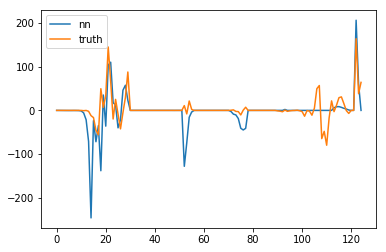

In [77]:
plt.plot(preds[510], label='nn')
plt.plot(y[510], label='truth')
plt.legend();
#plt.axis([0,50,-100,100])

TODO: Validation